*Contexto*

Ha surgido la idea de abrir un café operador por robots en Los Ángeles. El proyecto
es caro, por lo que se ha llamado a un grupo de inversionistas interesados en conocer las las condiciones actuales del mercado de la restauración.

Los datos proceden de fuentes abiertas sobre restaurantes en LA, almacenados en el archivo de extensión .csv rest_data_us.

Descripción de las columnas del dataframe
- *object_name* — nombre del establecimiento
- *chain* — establecimiento que pertenece a una cadena (TRUE/FALSE)
- *object_type* — tipo de establecimiento
- *address* — dirección
- *number* — número de asientos

*Indice de contenidos*

1. [Inicialización: Importar librerías](#1.-Inicialización:-Importar-librerías)
2. [Cargar los datos: lectura de los archivos csv](#2.-Cargar-los-datos:-lectura-de-los-archivos-csv)
3. [Descripción y preprocesamiento de los datos](#3-descripción-y-preprocesamiento-de-los-datos)
4. [Análisis exploratorio de datos](#2-análisis-exploratorio-de-datos)
5. [Conclusiones](#5.-Conclusiones)

# 1. Inicialización: Importar librerías 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as st
from matplotlib import pyplot as plt

# 2. Cargar los datos: lectura de los archivos csv

In [150]:
df = pd.read_csv('/datasets/rest_data_us.csv')

# 3. Descripción y preprocesamiento de los datos

Se usarán los métodos info() y head(), lo que entregará un resumen dl dataframe, y dará luz sobre qué tipo de correcciones puede hacerse en él de forma inicial.

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9651 entries, 0 to 9650
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           9651 non-null   int64 
 1   object_name  9651 non-null   object
 2   address      9651 non-null   object
 3   chain        9648 non-null   object
 4   object_type  9651 non-null   object
 5   number       9651 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 452.5+ KB


Se observan tres filas con datos nulos para la columna chain. Al representar solo un 0.03% del total del dataframe se eliminarán dichas filas. Además, los tipos de datos para cada columna son correctos por lo que no sufrirán modificaciones.

In [152]:
df = df.dropna()

Se verifica si la operación ha sido exitosa.

In [153]:
df.isnull().sum()

id             0
object_name    0
address        0
chain          0
object_type    0
number         0
dtype: int64

Ya no existen datos nulos en el dataframe, pero ahora se verificará si no existen duplicados.

In [154]:
duplicates = df[df.duplicated()]
duplicates

,id,object_name,address,chain,object_type,number


No se observan datos duplicados, por lo que ahora se procederá a imprimir una muestra del dataframe.

In [155]:
df.head()

,id,object_name,address,chain,object_type,number
0,11786,HABITAT COFFEE SHOP,3708 N EAGLE ROCK BLVD,False,Cafe,26
1,11787,REILLY'S,100 WORLD WAY # 120,False,Restaurant,9
2,11788,STREET CHURROS,6801 HOLLYWOOD BLVD # 253,False,Fast Food,20
3,11789,TRINITI ECHO PARK,1814 W SUNSET BLVD,False,Restaurant,22
4,11790,POLLEN,2100 ECHO PARK AVE,False,Restaurant,20


Se cuenta con cinco columnas que describen el nombre del servicio de restauración, su id, su dirección, su tipo, si pertenece a una cadena o no y la cantidad de asientos con las que cuenta. Conociendo esta información, se procederá con el análisis exploratorio de datos.

# 4. Análisis exploratorio de datos

## Tipos de establecimiento

Para comenzar el análisis, se investigará las proporciones de los distintos tipos de establecimientos.

In [156]:
establishment_type = df['object_type'].value_counts()
establishment_type

Restaurant    7253
Fast Food     1066
Cafe           435
Pizza          319
Bar            292
Bakery         283
Name: object_type, dtype: int64

La tabla muestra que la mayor parte de los establecimientos son restaurantes. Para conocer a que proporción corresponde se calculará el porcentaje de cada establecimiento.

In [157]:
establishment_type_percentages = (establishment_type / len(df)) * 100
establishment_type_percentages

Restaurant    75.176202
Fast Food     11.048922
Cafe           4.508706
Pizza          3.306385
Bar            3.026534
Bakery         2.933250
Name: object_type, dtype: float64

En efecto, un 75% de los establecimientos son restaurantes. Para visualizar de mejor manera la información de esta tabla se graficará su información en un gráfico circular con la librería seaborn.

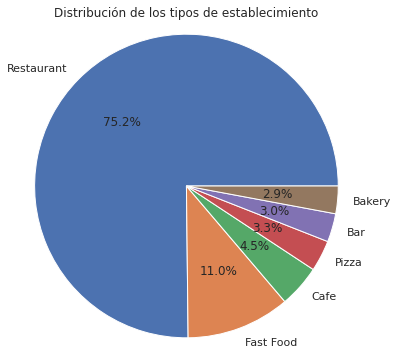

In [159]:
plt.figure(figsize=(6, 6)) 
plt.pie(establishment_type_percentages, labels=establishment_type_percentages.index, autopct='%1.1f%%')
plt.title("Distribución de los tipos de establecimiento")
plt.axis('equal')  
plt.show()

## Análisis de cadenas

Ahora que se sabe que el gran porcentaje de los establecimientos son restaurantes, el foco estará puesto en las cadenas, averiguando que proporciones de los establecimientos pertenecen a una, a qué tipo de establecimiento suelen corresponder y qué las caracteriza.

### Proporción de establecimientos que pertenecen a una cadena

Primero se contarán cuántos establecimientos corresponden a cadenas con el método value_counts().

In [161]:
is_a_chain = df['chain'].value_counts()
is_a_chain

False    5972
True     3676
Name: chain, dtype: int64

La mayor parte de los establecimientos no son cadenas, sin embargo, una proporción importante si pertenece a cadenas. El porcentaje que representa cada uno será calculado a continuación.

In [162]:
chain_percentages = (is_a_chain/ len(df)) * 100
chain_percentages

False    61.898839
True     38.101161
Name: chain, dtype: float64

Un 38% de los establecimientos son cadenas. Para que sea más fácil de visualizarlo, se trazará un gráfico circular.

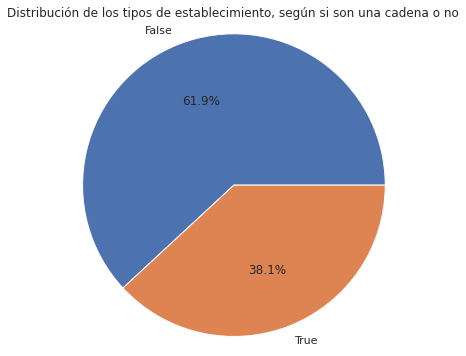

In [164]:
plt.figure(figsize=(6, 6)) 
plt.pie(chain_percentages, labels=chain_percentages.index, autopct='%1.1f%%')
plt.title("Distribución de los tipos de establecimiento, según si son una cadena o no")
plt.axis('equal')  
plt.show()

Ahora que es conocida la proporción de cadena, la pregunta a responder es a qué tipo de establecimiento corresponden. Para esto, se creará una tabla dinamica que de cuenta a qué tipo de establecimiento corresponden dichas cadenas.

In [165]:
chain_pivot = df[['chain','object_type','id']]
chain_pivot = pd.pivot_table(chain_pivot,index=['chain','object_type'],values='id',aggfunc='count')
chain_pivot

id
chain object_type      
False Bar           215
      Cafe          169
      Fast Food     461
      Pizza         166
      Restaurant   4961
True  Bakery        283
      Bar            77
      Cafe          266
      Fast Food     605
      Pizza         153
      Restaurant   2292

La información que nos interesa es aquella de las cadenas, por lo que se filtrará el dataframe bajo esa condición para crear un gráfico circular que ilustre como se distribuyen los establecimientos cuando corresponden a cadenas.

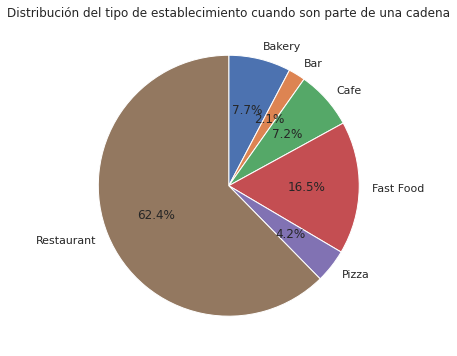

In [166]:
chain_pivot = chain_pivot.query('chain == True')

chain_pivot = chain_pivot.reset_index()

plt.figure(figsize=(6, 6))
plt.pie(chain_pivot['id'], labels=chain_pivot['object_type'], autopct='%1.1f%%', startangle=90, counterclock=False)
plt.title("Distribución del tipo de establecimiento cuando son parte de una cadena")

plt.show()

El gráfico muestra que un 62.4% de los establecimientos que pertenecen a cadenas son restaurantes, seguidos por cadenas de comida rápido y pastelerías.

### Cantidad de asientos en las cadenas

Para caracterizar a las cadenas, se usará como referencia el número de asientos. Primero se obtendrán estadísticas descriptivas sobre el número de asientos para todos los tipos de cadenas. 

In [167]:
is_chain_seat_num = df[df['chain'] == True]['number']
is_chain_seat_num.describe()

count    3676.000000
mean       39.694233
std        43.437212
min         1.000000
25%        13.000000
50%        25.000000
75%        44.000000
max       229.000000
Name: number, dtype: float64

La media en generall está en 39.69 asientos, con un máximo de 229 asientos, y un mínimo de un asiento.

Ahora se calculará la media de los asientos según el tipo de establecimiento.

In [168]:
chain_seats_by_type = df[df['chain'] == True].groupby('object_type')['number'].mean()

chain_seats_by_type

object_type
Bakery        21.773852
Bar           40.259740
Cafe          25.917293
Fast Food     38.089256
Pizza         25.529412
Restaurant    44.856021
Name: number, dtype: float64

Los restaurantes nuevamente lideran, esta vez con la cantidad de sillas. Se ilustrará la información de la tabla con un gráfico de barras usando la librería seaborn.

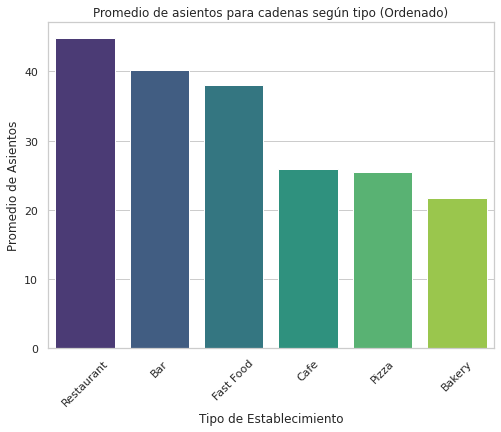

In [169]:
chain_seats_by_type = chain_seats_by_type.sort_values(ascending=False)

colors = sns.color_palette('viridis', len(chain_seats_by_type))

plt.figure(figsize=(8, 6))
sns.barplot(x=chain_seats_by_type.index, y=chain_seats_by_type.values, palette=colors)
plt.title("Promedio de asientos para cadenas según tipo (Ordenado)")
plt.xlabel("Tipo de Establecimiento")
plt.ylabel("Promedio de Asientos")

plt.xticks(rotation=45)

plt.show()

Los tres tipos de establecimientos con más asientos son los restaurantes, los bares y los locales de comida rápida, con más de 30 en promedio para cada uno.

## Análisis de calles

Ahora, el foco estará puesto en la ubicación greográfica de los restaurantes. En primer lugar, del datraframe original se dividirá la información de la columna address en dos: el número de la calle quedará almacenado en la columna address_number, mientras que el nombre quedará en la columna address_name. Dicha información se extraerá de la columna address, mediante, el método str.extract().

In [170]:
df[['address_number', 'address_name']] = df['address'].str.extract(r'^(\d+)\s(.+)$')
df

,id,object_name,address,chain,object_type,number,address_number,address_name
0,11786,HABITAT COFFEE SHOP,3708 N EAGLE ROCK BLVD,False,Cafe,26,3708,N EAGLE ROCK BLVD
1,11787,REILLY'S,100 WORLD WAY # 120,False,Restaurant,9,100,WORLD WAY # 120
2,11788,STREET CHURROS,6801 HOLLYWOOD BLVD # 253,False,Fast Food,20,6801,HOLLYWOOD BLVD # 253
3,11789,TRINITI ECHO PARK,1814 W SUNSET BLVD,False,Restaurant,22,1814,W SUNSET BLVD
4,11790,POLLEN,2100 ECHO PARK AVE,False,Restaurant,20,2100,ECHO PARK AVE
...,...,...,...,...,...,...,...,...
9646,21432,HALL OF JUSTICE,217 W TEMPLE AVE,False,Restaurant,122,217,W TEMPLE AVE
9647,21433,FIN-MELROSE,5750 MELROSE AVE,False,Restaurant,93,5750,MELROSE AVE
9648,21434,JUICY WINGZ,6741 HOLLYWOOD BLVD,True,Fast Food,15,6741,HOLLYWOOD BLVD
9649,21435,MEDIDATE COFFEE,548 S SPRING ST STE 100,False,Cafe,6,548,S SPRING ST STE 100


Ahora, se buscará cuáles son las calles con un mayor número de restaurantes, agrupando los restaurantes según su dirección con el método group.by() y luego informando dicha información de forma descendente mediante el método sort_values()

In [172]:
street_restaurant_counts = df[df['object_type'] == 'Restaurant'].groupby('address_name')['object_type'].count()

street_restaurant_counts = street_restaurant_counts.sort_values(ascending=False)

street_restaurant_counts

address_name
W PICO BLVD               218
W SUNSET BLVD             217
HOLLYWOOD BLVD            136
WILSHIRE BLVD             131
W 3RD ST                  119
                         ... 
S ARDMORE AVE STE 105       1
S ARDMORE AVE STE 100       1
S ARDMORE AVE STE #200      1
S ARDMORE AVE #100          1
hollywood BLVD              1
Name: object_type, Length: 2494, dtype: int64

La calle más popular es West Pico Boulevard, con 218 restaurantes.

### Las diez calles más populares según número de restaurantes

Se seleccionarán las 10 calles con más restaurantes y se visualizarán en un gráfico de barras.

In [175]:
top_10_streets = street_restaurant_counts.head(10)
top_10_streets

address_name
W PICO BLVD          218
W SUNSET BLVD        217
HOLLYWOOD BLVD       136
WILSHIRE BLVD        131
W 3RD ST             119
S VERMONT AVE        107
SANTA MONICA BLVD    107
W OLYMPIC BLVD       107
MELROSE AVE          106
BEVERLY BLVD         103
Name: object_type, dtype: int64

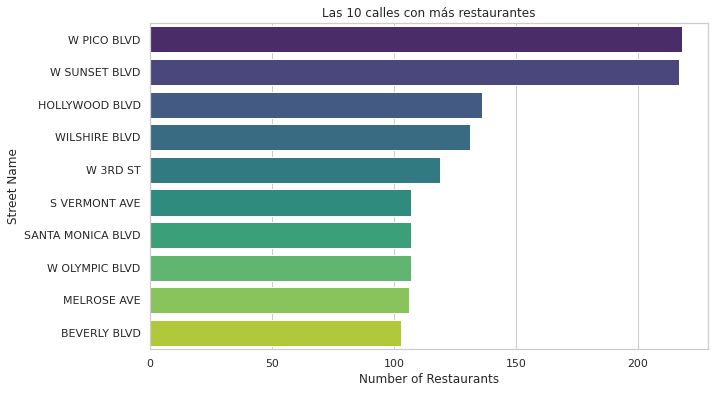

In [185]:
top_10_streets.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_streets.values, y=top_10_streets.index, palette='viridis')
plt.xlabel('Number of Restaurants')
plt.ylabel('Street Name')
plt.title('Las 10 calles con más restaurantes')

plt.show()

Tanto la calle West Pico Boulevard como West Sunset Boulevard superan los 200 restaurantes. El resto de las calles: Hollywood Boulevard, Wilshire Boulevard, West Third Street, South Vermont Avenue, Santa Monica Boulevard, West Olympic Boulevard, Melrose Avenue y Beverly Boulevard están en el ranto de entre 150 a 100 restaurantes, de mayor a menor.

Ahora se averiguará qué calles tienen solo un restaurante usando una expresión lógica.

In [178]:
streets_with_one_restaurant = street_restaurant_counts[street_restaurant_counts == 1]
streets_with_one_restaurant

address_name
W 3RD ST # 108            1
S VERMONT AVE STE 109     1
W 6TH ST # 11             1
S WESTERN AVE # B         1
W 3RD ST # 10-21          1
                         ..
S ARDMORE AVE STE 105     1
S ARDMORE AVE STE 100     1
S ARDMORE AVE STE #200    1
S ARDMORE AVE #100        1
hollywood BLVD            1
Name: object_type, Length: 1990, dtype: int64

In [179]:
total_streets_with_one_restaurant = street_restaurant_counts[street_restaurant_counts == 1].sum()
total_streets_with_one_restaurant 

1990

Del dataframe con el que se está trabajando, 1990 calles solo tienen un restaurante. 

### Calles con muchos restaurantes

Dada la gran dispersión de los datos, con calles con solo un restaurante y otras con más de 200, se buscará cuál es el promedio de restaurantes por calle.

In [181]:
street_restaurant_counts = df[df['object_type'] == 'Restaurant'].groupby('address_name')['object_type'].count()

avg_restaurants_per_street = street_restaurant_counts.mean()

avg_restaurants_per_street

2.904971932638332

El promedio de restaurantes por calle es dos, por lo tanto, se establecerá que una calle con muchos restaurantes equivaldrá a una calle co más de 10 restaurantes. A continuación se separará dicho dataframe.

In [182]:
streets_with_more_than_10 = street_restaurant_counts[street_restaurant_counts > 100]

filtered_df = df[df['address_name'].isin(streets_with_more_than_10.index)]

filtered_df

,id,object_name,address,chain,object_type,number,address_number,address_name
3,11789,TRINITI ECHO PARK,1814 W SUNSET BLVD,False,Restaurant,22,1814,W SUNSET BLVD
10,11796,EL POLLO LOCO,5319 W SUNSET BLVD,True,Restaurant,38,5319,W SUNSET BLVD
16,11802,HMS BOUNTY,3357 WILSHIRE BLVD,False,Restaurant,147,3357,WILSHIRE BLVD
18,11804,MURAKAMI,7160 MELROSE AVE,False,Restaurant,139,7160,MELROSE AVE
22,11808,CAMY'S GRILL,3339 WILSHIRE BLVD,False,Restaurant,39,3339,WILSHIRE BLVD
...,...,...,...,...,...,...,...,...
9625,21411,EAT THIS CAFE,6545 SANTA MONICA BLVD,False,Restaurant,41,6545,SANTA MONICA BLVD
9628,21414,KIFF KAFE,12217 W PICO BLVD,False,Restaurant,29,12217,W PICO BLVD
9630,21416,SALVATORE'S ON MELROSE,7356 MELROSE AVE,False,Restaurant,101,7356,MELROSE AVE
9647,21433,FIN-MELROSE,5750 MELROSE AVE,False,Restaurant,93,5750,MELROSE AVE


### Promedio de asientos por restaurante en las calles más populares

A continuación se averiguará cuántos asientos tienen en promedio los restaurantes en las calles que fueron identificadas como las más populares según el número de restaurantes.

In [183]:
average_seats_per_restaurant = filtered_df.groupby('address_name')['number'].mean().sort_values(ascending=False)

average_seats_per_restaurant

address_name
WILSHIRE BLVD        62.130435
W OLYMPIC BLVD       57.887097
HOLLYWOOD BLVD       53.730539
MELROSE AVE          52.429688
W SUNSET BLVD        50.918919
S VERMONT AVE        45.878378
BEVERLY BLVD         44.770370
W 3RD ST             43.931034
W PICO BLVD          40.878472
SANTA MONICA BLVD    32.390411
Name: number, dtype: float64

La calle cuyos restaurantes tienen más asientos en promedio es Wilshire Boulevard, con 62.13 asientos. A continuación, se graficará la información anterior con un gráfico de barras.

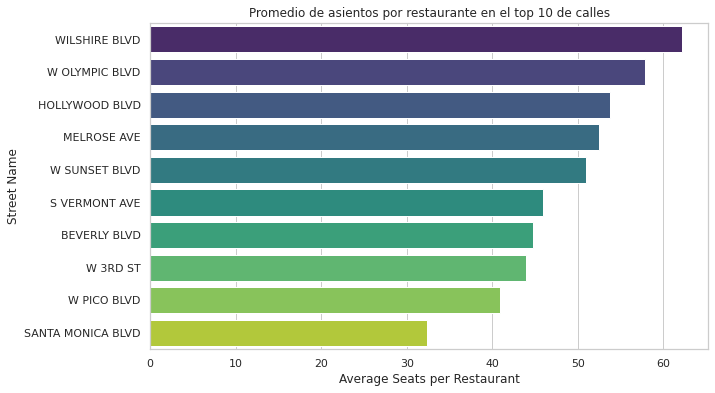

In [186]:
average_seats_per_restaurant = filtered_df.groupby('address_name')['number'].mean().reset_index()
average_seats_per_restaurant = average_seats_per_restaurant.sort_values(by='number', ascending=False)  

plt.figure(figsize=(10, 6))
sns.barplot(x='number', y='address_name', data=average_seats_per_restaurant, palette='viridis')
plt.xlabel('Average Seats per Restaurant')
plt.ylabel('Street Name')
plt.title('Promedio de asientos por restaurante en el top 10 de calles')

plt.show()

Se observa como la calle Wilshire Boulevard lidera en cuanto al promedio de asientos por restaurantes, con más de 60 en promedio, seguida por West Olympic Boulevard, Hollywood Boulevard, Melrose Avenue y West Sunset Boulevard que tienen más de 50 asientos en promedio. La calle con menos asientos en promedio es Santa Monica Boulevard, con más de 30 asientos en promedio.

# 5. Conclusiones

- Los Angeles tiene una industria de la restauración dominada por los restaurantes, donde ellos representan el 75% de la industria, mientras que los cafés solo acaparan un 4.5% de esta.
- Un 38.1% de los establecimientos de restauración forman parte de cadenas. 
- Dentro de las cadenas, un 7.2% de ellas son cadenas de café.
- Los cafés de dichas cadenas suelen tener un promedio de 26 asientos.
- Respecto a calles populares en términos de restaurantes, West Pico Boulevard es la calle con más restaurantes, mientras que la calle con más asientos en promedio por restaurante es Wilshire Boulevard.
- Como recomendaciones, considerando el tipo de establecimiento (café), la novedad del servicio (meseros robotizados) y las condiciones actuales del mercado, se puede recomendar que para abrir el café, es necesario buscar un lugar con espacio suficiente para por lo menos poner el promedio de 26 asientos, y debería estar localizado en cualquiera de las calles del top 10 con más restaurantes ya que son calles establecidas como zonas de restauración, lo que atraerá a nuevos clientes por la posición geográfica tan estratégica. Sin embargo, no se recomienda comenzar como una cadena ya que los costos del proyecto son muy altos al buscar establecerse con un amplio espacio dentro de calles tan populares. Sin embargo, es algo que se puede volver a evaluar en el tiempo en función de los resultados que esté entregando esta nueva empresa.